<a href="https://colab.research.google.com/github/SasikaA073/Computational-photography-m/blob/main/CycleGAN_horse_zebra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN

## Architecture

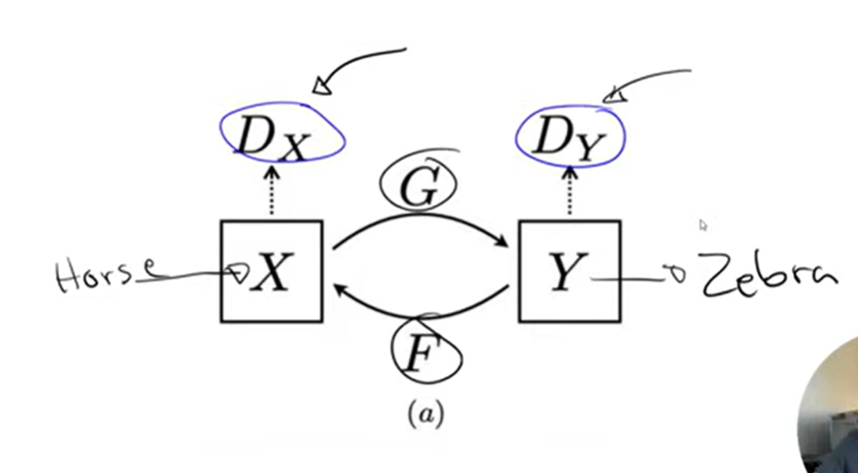

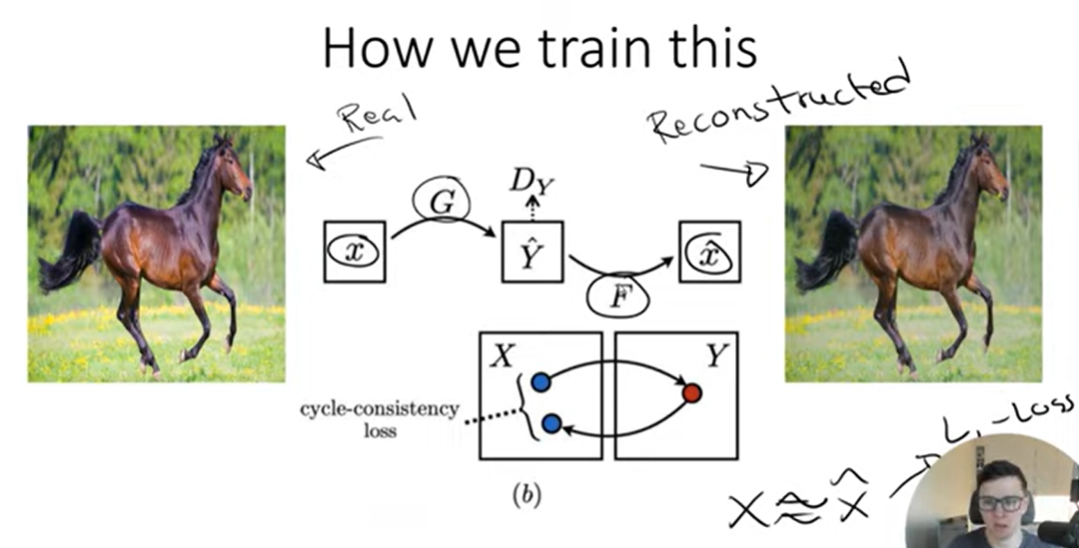

## Loss (summary)

* Identity Loss is not used for every dataset

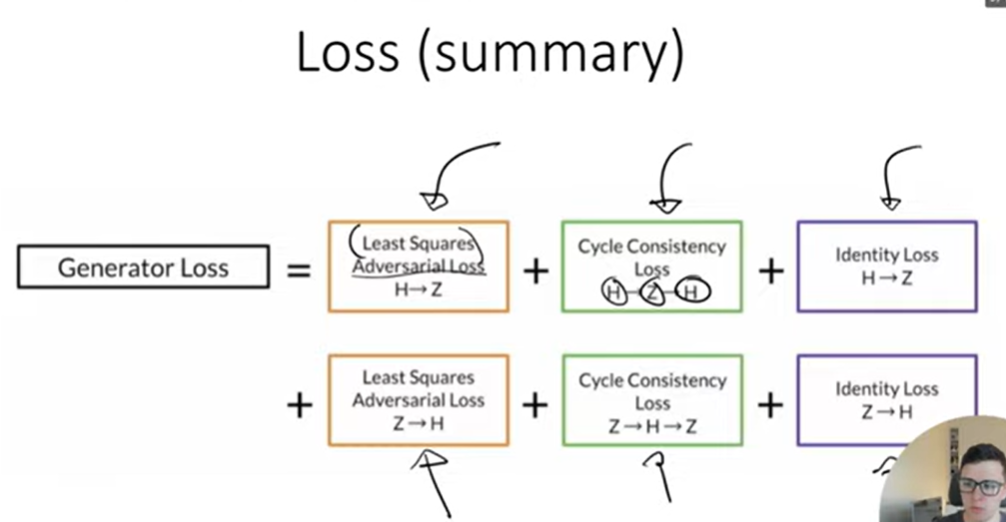

## Configuration

In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
os.chdir("/content/drive/MyDrive/CycleGAN/")


In [ ]:
# # Configuration setup from the CycleGAN paper

# import torch
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# TRAIN_DIR = "/content/horse2zebra/horse2zebra/train/"
# VAL_DIR = "/content/horse2zebra/horse2zebra/val/"
# BATCH_SIZE = 1
# LEARNING_RATE = 1e-5
# LAMBDA_IDENTITY = 0.0
# LAMBDA_CYCLE = 10
# NUM_WORKERS = 4
# NUM_EPOCHS = 1
# LOAD_MODEL = False
# SAVE_MODEL = True
# CHECKPOINT_GEN_H = "genh.pth.tar"
# CHECKPOINT_GEN_Z = "genz.pth.tar"
# CHECKPOINT_CRITIC_H = "critich.pth.tar"
# CHECKPOINT_CRITIC_Z = "criticz.pth.tar"

# transforms = A.Compose(
#     [
#         A.Resize(width=256, height=256),
#         A.HorizontalFlip(p=0.5),
#         A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
#         ToTensorV2(),
#     ],
#     additional_targets={"image0": "image"},
# )


## Utils.py


In [ ]:
import random, torch, os, numpy as np
import torch.nn as nn
import config
import copy

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Horse, Zebra dataset

### Download Kaggle Dataset

In [ ]:
# from google.colab import files

# files.upload() #this will prompt you to upload the kaggle.json

In [ ]:
# !ls -lha kaggle.json

In [ ]:

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !pwd


In [ ]:
# !kaggle datasets list

In [ ]:
# !kaggle datasets download -d suyashdamle/cyclegan

In [ ]:
!unzip /content/cyclegan.zip;

In [ ]:
# prompt: unzip "/content/drive/MyDrive/CycleGAN/horse2zebra.zip" to "/content/"

!unzip "/content/drive/MyDrive/CycleGAN/horse2zebra.zip" -d "/content/"


### Configure dataset

In [ ]:
import torch
from PIL import Image
import os
# import config
import numpy as np
from torch.utils.data import Dataset, DataLoader

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        super().__init__()

        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images))   # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path).convert("RGB"))
        horse_img = np.array(Image.open(horse_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img)
            zebra_img = augmentations["image"]
            horse_img = augmentations["image0"]

        return zebra_img, horse_img

## Generator

In [ ]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True,**kwargs):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs) if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1)  # meaning use_act ?
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels,num_features = 64, num_residuals=9):
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True)
        )

        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1)
            ])

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )

        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features, down=False, kernel_size=3, stride=2, padding=1, output_padding=1)
            ]
        )

        self.last = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")


    def forward(self, x):
        x = self.initial(x)

        for layer in self.down_blocks:
            x = layer(x)

        x = self.residual_blocks(x)

        for layer in self.up_blocks:
            x = layer(x)

        return torch.tanh(self.last(x))


def test_generator():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels)
    print(gen(x).shape)

# if __name__ == "__main__":
test_generator()

## Discriminator

In [ ]:
import torch
import torch.nn as nn


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    # what does LeakyRelu does
    # what does padding_mode does? What are the available padding modes
    # what does instanceNOrm does?

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):

    def __init__(self, in_channels=3, features=[64, 128, 256, 512]) -> None:
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels,
                      features[0],
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )


        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature

        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

def test_discriminator():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds.shape)

# if __name__ == "__main__":
test_discriminator()

## Training

In [ ]:
config.NUM_EPOCHS

In [ ]:
save_path = "/content/drive/MyDrive/CycleGAN/saved_images/"

train_path = "/content/content/horse2zebra/horse2zebra/train/"
val_path = "/content/content/horse2zebra/horse2zebra/val"

In [ ]:
import torch
from dataset import HorseZebraDataset
import sys
from utils import save_checkpoint, load_checkpoint
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import config
from tqdm import tqdm
from torchvision.utils import save_image
# from discriminator_model import Discriminator
# from generator_model import Generator

def train_fn(disc_H, disc_Z, gen_H, gen_Z, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler, dataloader):
    # get a progress bar
    loop = tqdm(dataloader, leave=True)

    for idx, (zebra, horse) in enumerate(loop):
        zebra = zebra.to(config.DEVICE)
        horse = horse.to(config.DEVICE)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_zebra = gen_H(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_H(fake_zebra.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            # put it together
            D_loss = (D_H_loss + D_Z_loss)/2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward() # what does this do?
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            D_H_fake = disc_H(fake_horse)
            D_Z_fake = disc_Z(fake_zebra)

            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle loss
            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            cycle_zebra_loss = L1(zebra, cycle_zebra)
            cycle_horse_loss = L1(horse, cycle_horse)

            # identity loss
            identity_zebra = gen_Z(zebra)
            identity_horse = gen_H(horse)
            identity_zebra_loss = L1(zebra, identity_zebra)
            identity_horse_loss = L1(horse, identity_horse)

            # add all together
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_zebra_loss * config.LAMBDA_CYCLE
                + cycle_horse_loss * config.LAMBDA_CYCLE
                + identity_horse_loss * config.LAMBDA_IDENTITY
                + identity_zebra_loss * config.LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_horse*0.5+0.5, f"{save_path}/horse_{idx}.png")
            save_image(fake_zebra*0.5+0.5, f"{save_path}/zebra_{idx}.png")


def main_function():
    disc_H = Discriminator(in_channels=3).to(config.DEVICE)
    disc_Z = Discriminator(in_channels=3).to(config.DEVICE)
    gen_H = Generator(img_channels=3, num_residuals=9).to(config.DEVICE)
    gen_Z = Generator(img_channels=3, num_residuals=9).to(config.DEVICE)

    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=config.LEARNING_RATE,
        betas=(0.5, 0.999), # beta1 = 0.5, beta2 = 0.999 described as in the paper
    )

    opt_gen = optim.Adam(
        list(gen_H.parameters()) + list(gen_Z.parameters()),
        lr=config.LEARNING_RATE,
        betas=(0.5, 0.999), # beta1 = 0.5, beta2 = 0.999 described as in the paper
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if config.LOAD_MODEL:
        load_checkpoint(
            config.CHECKPOINT_GEN_H, gen_H, opt_gen, config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_GEN_Z, gen_Z, opt_gen, config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_CRITIC_H, disc_H, opt_disc, config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_CRITIC_Z, disc_Z, opt_disc, config.LEARNING_RATE,
        )

    dataset = HorseZebraDataset(
        root_horse=  train_path + "horse",
        root_zebra= train_path + "zebra",
        transform=config.transforms
    )

    dataloader = DataLoader(
        dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,  # what does this do?
        pin_memory=True # what does this do?
    )

    g_scale = torch.cuda.amp.GradScaler()
    d_scale = torch.cuda.amp.GradScaler()

    for epoch in range(config.NUM_EPOCHS):
        train_fn(disc_H, disc_Z, gen_H, gen_Z, opt_disc, opt_gen, L1, mse, d_scale, g_scale, dataloader)

        if config.SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename=config.CHECKPOINT_GEN_H)
            save_checkpoint(gen_Z, opt_gen, filename=config.CHECKPOINT_GEN_Z)
            save_checkpoint(disc_H, opt_disc, filename=config.CHECKPOINT_CRITIC_H)
            save_checkpoint(disc_Z, opt_disc, filename=config.CHECKPOINT_CRITIC_Z)

# if __name__ == "__main__":
#     main()

main_function()

In [ ]:
# prompt: zip "/content/horse2zebra/horse2zebra" folder

# !zip -r /content/horse2zebra.zip /content/horse2zebra/horse2zebra


In [ ]:
# prompt: move "/content/horse2zebra.zip" to "/content/drive/MyDrive/CycleGAN"

# !cp -r /content/horse2zebra.zip /content/drive/MyDrive/CycleGAN
